In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Getting the data

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
# import zipfile
# from tqdm import tqdm

# zip_file_path = '/content/drive/MyDrive/data_egr598/main_data/maindata.zip'
# extract_path = '/content/drive/MyDrive/data_egr598/main_data/'

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     files = zip_ref.namelist()
#     for file in tqdm(files, desc="Extracting", unit="files"):
#         zip_ref.extract(file, extract_path)

In [33]:
df1=pd.read_csv('/content/drive/MyDrive/data_egr598/main_data/maindata/data_02/data.csv')
df2=pd.read_csv('/content/drive/MyDrive/data_egr598/main_data/maindata/data_03/data.csv')
df3=pd.read_csv('/content/drive/MyDrive/data_egr598/main_data/maindata/data_01/data.csv')


In [34]:
# Remove the 'data/' prefix from the image_path column
df1['image_path'] = df1['image_path'].str.replace('data/', '')
df2['image_path'] = df2['image_path'].str.replace('data/', '')
df3['image_path'] = df3['image_path'].str.replace('data/', '')


# Add the '/content/drive/MyDrive/data_egr598/' prefix to the image_path column
df1['image_path'] = '/content/drive/MyDrive/data_egr598/main_data/maindata/data_02/' + df1['image_path'].str.replace('.png', '.png')
df2['image_path'] = '/content/drive/MyDrive/data_egr598/main_data/maindata/data_03/' + df2['image_path'].str.replace('.png', '.png')
df3['image_path'] = '/content/drive/MyDrive/data_egr598/main_data/maindata/data_01/' + df3['image_path'].str.replace('.png', '.png')

<ipython-input-34-4894ade7b88f>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['image_path'] = '/content/drive/MyDrive/data_egr598/main_data/maindata/data_02/' + df1['image_path'].str.replace('.png', '.png')
<ipython-input-34-4894ade7b88f>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['image_path'] = '/content/drive/MyDrive/data_egr598/main_data/maindata/data_03/' + df2['image_path'].str.replace('.png', '.png')
<ipython-input-34-4894ade7b88f>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df3['image_path'] = '/content/drive/MyDrive/data_egr598/main_data/maindata/data_01/' + df3['image_path'].str.replace('.png', '.png')


In [35]:
# Add a column to each dataframe to indicate the source
df1['source'] = 'data_02'
df2['source'] = 'data_03'
df3['source'] = 'data_01'

In [36]:
# Combine the dataframes into one dataframe
df = pd.concat([df1, df2, df3], ignore_index=True)
df.head()

,timestamp,image_path,linear_x,angular_z,source
0,1.681957e+09,/content/drive/MyDrive/data_egr598/main_data/m...,0.0,0.0,data_02
1,1.681957e+09,/content/drive/MyDrive/data_egr598/main_data/m...,0.0,0.0,data_02
2,1.681957e+09,/content/drive/MyDrive/data_egr598/main_data/m...,0.0,0.0,data_02
3,1.681957e+09,/content/drive/MyDrive/data_egr598/main_data/m...,0.0,0.0,data_02
4,1.681957e+09,/content/drive/MyDrive/data_egr598/main_data/m...,0.0,0.0,data_02


<Axes: xlabel='angular_z', ylabel='Count'>

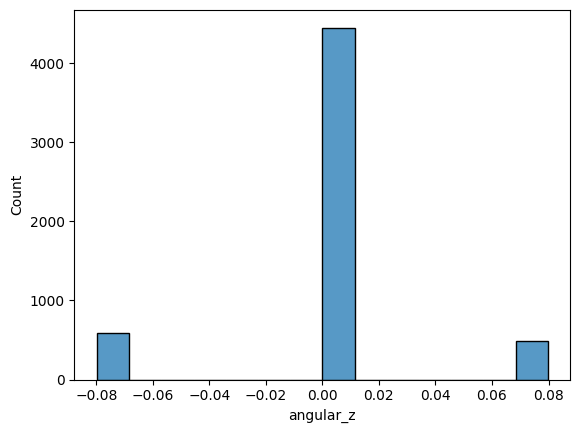

In [37]:
# Plot the histogram using Seaborn
sns.histplot(data=df, x='angular_z')

In [38]:
df['angular_z'].value_counts()

 0.000000    4448
-0.079766     587
 0.079766     491
Name: angular_z, dtype: int64

In [39]:
# Get 1200 samples for each unique value of angular_z, except for 0.00000
sample_size = 450
unique_z = df['angular_z'].unique()

sampled_data = pd.concat([
    df[df['angular_z'] == z].sample(n=sample_size, random_state=42, replace=True)
    if z != 0.0 else
    df[df['angular_z'] == z].sample(n=900, random_state=42, replace=True)
    for z in unique_z
])

# Reset the index of the sampled data
sampled_data = sampled_data.reset_index(drop=True)

In [40]:
sampled_data['angular_z'].value_counts()

 0.000000    900
 0.079766    450
-0.079766    450
Name: angular_z, dtype: int64

<Axes: xlabel='angular_z', ylabel='Count'>

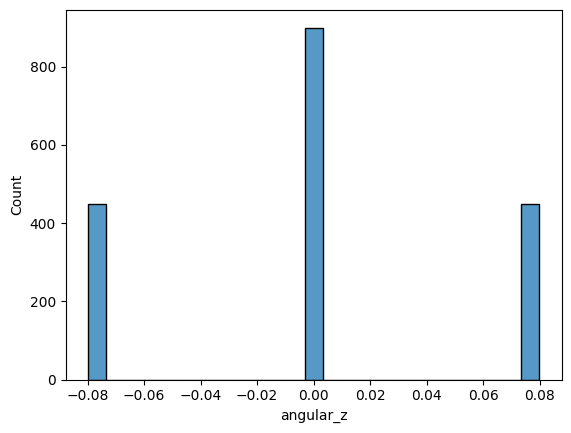

In [41]:
# Plot the histogram using Seaborn
sns.histplot(data=sampled_data, x='angular_z')

# View & process the images

# Build the model

In [13]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   1800 non-null   float64
 1   image_path  1800 non-null   object 
 2   linear_x    1800 non-null   float64
 3   angular_z   1800 non-null   float64
 4   source      1800 non-null   object 
dtypes: float64(3), object(2)
memory usage: 70.4+ KB


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tqdm import tqdm  # Import the tqdm library
from concurrent.futures import ThreadPoolExecutor

# Preprocess the images
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return img_array

# Process images in parallel
def process_images_parallel(image_paths, target_size=(224, 224)):
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(preprocess_image, img_path, target_size) for img_path in image_paths]
        results = [f.result() for f in tqdm(futures, desc="Processing images")]
    return results

images = np.array(process_images_parallel(sampled_data["image_path"]))

# Preprocess the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(sampled_data["angular_z"])
labels = to_categorical(labels)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # We have 3 distinct labels
])

model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Processing images: 100%|██████████| 1800/1800 [00:44<00:00, 40.27it/s]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [15]:
# Save the model
model.save("my_model.h5")

In [16]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(X_val, y_val)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

# Predict the angular_z values for the validation images
y_val_pred_prob = model.predict(X_val)

# Convert the predictions to label indices
y_val_pred_indices = np.argmax(y_val_pred_prob, axis=1)

# Convert the label indices back to original angular_z values
y_val_pred = label_encoder.inverse_transform(y_val_pred_indices)

# Convert the one-hot encoded y_val back to original angular_z values
y_val_original = label_encoder.inverse_transform(np.argmax(y_val, axis=1))

# Calculate the accuracy
accuracy = np.mean(y_val_original == y_val_pred)
print(f"Accuracy on validation set: {accuracy:.2%}")

# Compare the actual angular_z with the predicted angular_z
comparison = pd.DataFrame({"Actual": y_val_original, "Predicted": y_val_pred})
print(comparison.head())


12/12 [==============================] - 0s 26ms/step - loss: 0.1549 - accuracy: 0.9639
Validation Loss: 0.15486732125282288
Validation Accuracy: 0.9638888835906982
12/12 [==============================] - 0s 23ms/step
Accuracy on validation set: 96.39%
     Actual  Predicted
0 -0.079766  -0.079766
1  0.079766   0.079766
2  0.000000   0.000000
3  0.000000   0.000000
4  0.079766   0.079766


## Test the base model

In [17]:
test_df=pd.read_csv('/content/drive/MyDrive/data_egr598/main_data/maindata/data/data.csv')

# Remove the 'data/' prefix from the image_path column
test_df['image_path'] = test_df['image_path'].str.replace('data/', '')


# Add the '/content/drive/MyDrive/data_egr598/' prefix to the image_path column
test_df['image_path'] = '/content/drive/MyDrive/data_egr598/main_data/maindata/data/' + test_df['image_path'].str.replace('.png', '.png')


<ipython-input-17-14c3dd6479d6>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['image_path'] = '/content/drive/MyDrive/data_egr598/main_data/maindata/data/' + test_df['image_path'].str.replace('.png', '.png')


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm  # Import the tqdm library
from concurrent.futures import ThreadPoolExecutor

# Preprocess the images
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return img_array

# Process images in parallel
def process_images_parallel(image_paths, target_size=(224, 224)):
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(preprocess_image, img_path, target_size) for img_path in image_paths]
        results = [f.result() for f in tqdm(futures, desc="Processing images")]
    return results

images = np.array(process_images_parallel(test_df["image_path"]))

# Preprocess the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(test_df["angular_z"])
labels = to_categorical(labels)

# Assuming the images are loaded and preprocessed into X_test and corresponding angular_z values are in y_test
X_test, y_test = images, labels

# Predict the angular_z values for the test images
y_test_pred_prob = model.predict(X_test)

# Convert the predictions to label indices
y_test_pred_indices = np.argmax(y_test_pred_prob, axis=1)

# Convert the label indices back to original angular_z values
y_test_pred = label_encoder.inverse_transform(y_test_pred_indices)

# Convert the one-hot encoded y_test back to original angular_z values
y_test_original = label_encoder.inverse_transform(np.argmax(y_test, axis=1))

# Calculate the accuracy
accuracy = np.mean(y_test_original == y_test_pred)
print(f"Accuracy on test set: {accuracy:.2%}")

# Compare the actual angular_z with the predicted angular_z
comparison = pd.DataFrame({"Actual": y_test_original, "Predicted": y_test_pred})
print(comparison.head())

Processing images: 100%|██████████| 1798/1798 [00:51<00:00, 34.73it/s]


57/57 [==============================] - 1s 21ms/step
Accuracy on test set: 77.70%
   Actual  Predicted
0     0.0        0.0
1     0.0        0.0
2     0.0        0.0
3     0.0        0.0
4     0.0        0.0


# Transfer learning model

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.applications import VGG16


# Load the VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # We have 3 distinct labels
])

model.summary()

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Learning rate scheduling
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_callback, early_stopping])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 27,561,795
Trainable params: 12,847,107
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/20
45/45 [===============

In [46]:
# Save the model
model.save("my_model_transfer.h5")

In [47]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(X_val, y_val)

print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)


12/12 [==============================] - 2s 124ms/step - loss: 0.2800 - accuracy: 0.9028
Validation Loss: 0.27999863028526306
Validation Accuracy: 0.9027777910232544


In [48]:
# Predict the angular_z values for the validation images
y_val_pred_prob = model.predict(X_val)

# Convert the predictions to label indices
y_val_pred_indices = np.argmax(y_val_pred_prob, axis=1)

# Convert the label indices back to original angular_z values
y_val_pred = label_encoder.inverse_transform(y_val_pred_indices)

# Convert the one-hot encoded y_val back to original angular_z values
y_val_original = label_encoder.inverse_transform(np.argmax(y_val, axis=1))

# Calculate the accuracy
accuracy = np.mean(y_val_original == y_val_pred)
print(f"Accuracy on validation set: {accuracy:.2%}")

# Compare the actual angular_z with the predicted angular_z
comparison = pd.DataFrame({"Actual": y_val_original, "Predicted": y_val_pred})
print(comparison.head())


12/12 [==============================] - 1s 128ms/step
Accuracy on validation set: 90.28%
     Actual  Predicted
0 -0.079766  -0.079766
1  0.079766   0.079766
2  0.000000   0.000000
3  0.000000   0.000000
4  0.079766   0.079766


In [49]:
comparison.head(20)

,Actual,Predicted
0,-0.079766,-0.079766
1,0.079766,0.079766
2,0.000000,0.000000
3,0.000000,0.000000
4,0.079766,0.079766
5,0.000000,0.000000
6,0.000000,0.000000
7,0.000000,0.000000
8,-0.079766,-0.079766
9,0.079766,0.079766


## Test the transfer learning model

In [50]:
test_df=pd.read_csv('/content/drive/MyDrive/data_egr598/main_data/maindata/data/data.csv')

# Remove the 'data/' prefix from the image_path column
test_df['image_path'] = test_df['image_path'].str.replace('data/', '')


# Add the '/content/drive/MyDrive/data_egr598/' prefix to the image_path column
test_df['image_path'] = '/content/drive/MyDrive/data_egr598/main_data/maindata/data/' + test_df['image_path'].str.replace('.png', '.png')


<ipython-input-50-14c3dd6479d6>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['image_path'] = '/content/drive/MyDrive/data_egr598/main_data/maindata/data/' + test_df['image_path'].str.replace('.png', '.png')


In [51]:
test_df['image_path'][1]

'/content/drive/MyDrive/data_egr598/main_data/maindata/data/1681957757.573238.png'

In [52]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798 entries, 0 to 1797
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   1798 non-null   float64
 1   image_path  1798 non-null   object 
 2   linear_x    1798 non-null   float64
 3   angular_z   1798 non-null   float64
dtypes: float64(3), object(1)
memory usage: 56.3+ KB


In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm  # Import the tqdm library
from concurrent.futures import ThreadPoolExecutor

# Preprocess the images
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return img_array

# Process images in parallel
def process_images_parallel(image_paths, target_size=(224, 224)):
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(preprocess_image, img_path, target_size) for img_path in image_paths]
        results = [f.result() for f in tqdm(futures, desc="Processing images")]
    return results

images = np.array(process_images_parallel(test_df["image_path"]))

# Preprocess the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(test_df["angular_z"])
labels = to_categorical(labels)

# Assuming the images are loaded and preprocessed into X_test and corresponding angular_z values are in y_test
X_test, y_test = images, labels

# Predict the angular_z values for the test images
y_test_pred_prob = model.predict(X_test)

# Convert the predictions to label indices
y_test_pred_indices = np.argmax(y_test_pred_prob, axis=1)

# Convert the label indices back to original angular_z values
y_test_pred = label_encoder.inverse_transform(y_test_pred_indices)

# Convert the one-hot encoded y_test back to original angular_z values
y_test_original = label_encoder.inverse_transform(np.argmax(y_test, axis=1))

# Calculate the accuracy
accuracy = np.mean(y_test_original == y_test_pred)
print(f"Accuracy on test set: {accuracy:.2%}")

# Compare the actual angular_z with the predicted angular_z
comparison = pd.DataFrame({"Actual": y_test_original, "Predicted": y_test_pred})
print(comparison.head())


Processing images: 100%|██████████| 1798/1798 [00:04<00:00, 373.87it/s]


57/57 [==============================] - 7s 130ms/step
Accuracy on test set: 88.21%
   Actual  Predicted
0     0.0        0.0
1     0.0        0.0
2     0.0        0.0
3     0.0        0.0
4     0.0        0.0


In [ ]:
# Find the mismatched rows
mismatches = comparison[comparison["Actual"] != comparison["Predicted"]]
mismatches

In [54]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798 entries, 0 to 1797
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   1798 non-null   float64
 1   image_path  1798 non-null   object 
 2   linear_x    1798 non-null   float64
 3   angular_z   1798 non-null   float64
dtypes: float64(3), object(1)
memory usage: 56.3+ KB


# Transfer learning model with data augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import LeakyReLU, ELU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta

# Load the VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Learning rate scheduling
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = LearningRateScheduler(lr_scheduler)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Create and train model function
def create_and_train_model(activation, optimizer):
    if activation == "leaky_relu":
        activation_layer = LeakyReLU(alpha=0.1)
    elif activation == "elu":
        activation_layer = ELU()
    elif activation == "sigmoid":
        activation_layer = Activation('sigmoid')
    elif activation == "tanh":
        activation_layer = Activation('tanh')
    else:  # Default is ReLU
        activation_layer = Activation('relu')

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512),
        activation_layer,
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                        epochs=10,
                        validation_data=(X_val, y_val),
                        callbacks=[lr_callback, early_stopping])
    
    return history, model

# Create a list of activation functions and optimizers to test
activation_functions = ["relu", "leaky_relu", "elu", "sigmoid", "tanh"]
optimizers = [Adam(), SGD(), RMSprop(), Adagrad(), Adadelta()]

best_model = None
best_history = None
best_accuracy = 0

# Test all combinations of activation functions and optimizers
for activation in activation_functions:
    for optimizer in optimizers:
        print(f"Testing model with activation={activation} and optimizer={optimizer.__class__.__name__}")
        history, model = create_and_train_model(activation, optimizer)
        val_accuracy = history.history['val_accuracy'][-1]
        
        if val_accuracy > best_accuracy:
            best_model = model
            best_history = history
            best_accuracy = val_accuracy
            print(f"New best model found with val_accuracy={best_accuracy}")

print("Training complete. Best model has activation={} and optimizer={}".format(
    best_model.layers[2].__class__.__name__, best_model.optimizer.__class__.__name__))


Testing model with activation=relu and optimizer=Adam
Epoch 1/10
45/45 [==============================] - 25s 531ms/step - loss: 2.1010 - accuracy: 0.5250 - val_loss: 0.5839 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - 20s 433ms/step - loss: 0.7601 - accuracy: 0.6542 - val_loss: 0.5209 - val_accuracy: 0.8028 - lr: 0.0010
Epoch 3/10
45/45 [==============================] - 22s 476ms/step - loss: 0.6762 - accuracy: 0.6819 - val_loss: 0.4639 - val_accuracy: 0.7917 - lr: 0.0010
Epoch 4/10
45/45 [==============================] - 21s 469ms/step - loss: 0.6228 - accuracy: 0.7222 - val_loss: 0.4317 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 5/10
45/45 [==============================] - 21s 473ms/step - loss: 0.5930 - accuracy: 0.7354 - val_loss: 0.4072 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 6/10
45/45 [==============================] - 21s 468ms/step - loss: 0.5157 - accuracy: 0.7618 - val_loss: 0.3978 - val_accuracy: 0.8250 - lr: 9.0484e-04
Epoch 